# Task 4 - Email Spam Detection With Machine Learning

### Import Libraries

In [6]:
# Data Cleaning
import pandas as pd

# Data Visualizing
import matplotlib.pyplot as plt
import seaborn as sns

# Word Cloud
import wordcloud

# Text Preprocessing
import string
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Preparing and Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MaxAbsScaler

# Models
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Model Saving
import pickle

### Read Data

In [7]:
df = pd.read_csv('./spam.csv', encoding="ISO-8859-1")

df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


### Data Wrangling & Visualization

#### Drop unnecessary columns and rename features

In [8]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis='columns', inplace=True)
df.rename(columns={'v1':'label', 'v2':'text'}, inplace=True)

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


#### Check data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


We can see no missing values in the remaining data

In [10]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [11]:
df.groupby('label').describe()

text                                                               
      count unique                                                top freq
label                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

We can see the data contains only 'ham' and 'spam', and most of the data are 'ham'

#### Check data distribution

<AxesSubplot: xlabel='label', ylabel='count'>

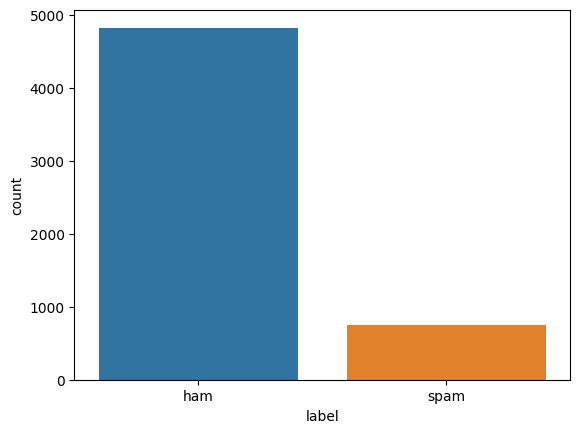

In [12]:
sns.countplot(data=df, x='label')

#### Get dummy variables for 'label'

In [13]:
dummies = pd.get_dummies(data=df['label'], drop_first=True)
df = pd.concat([df, dummies], axis='columns')

df.head()

,label,text,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


#### Add 'length' feature

In [14]:
df['length'] = df['text'].apply(len)

df.head()

,label,text,spam,length
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


#### Check relation between length and label

<AxesSubplot: xlabel='length', ylabel='Count'>

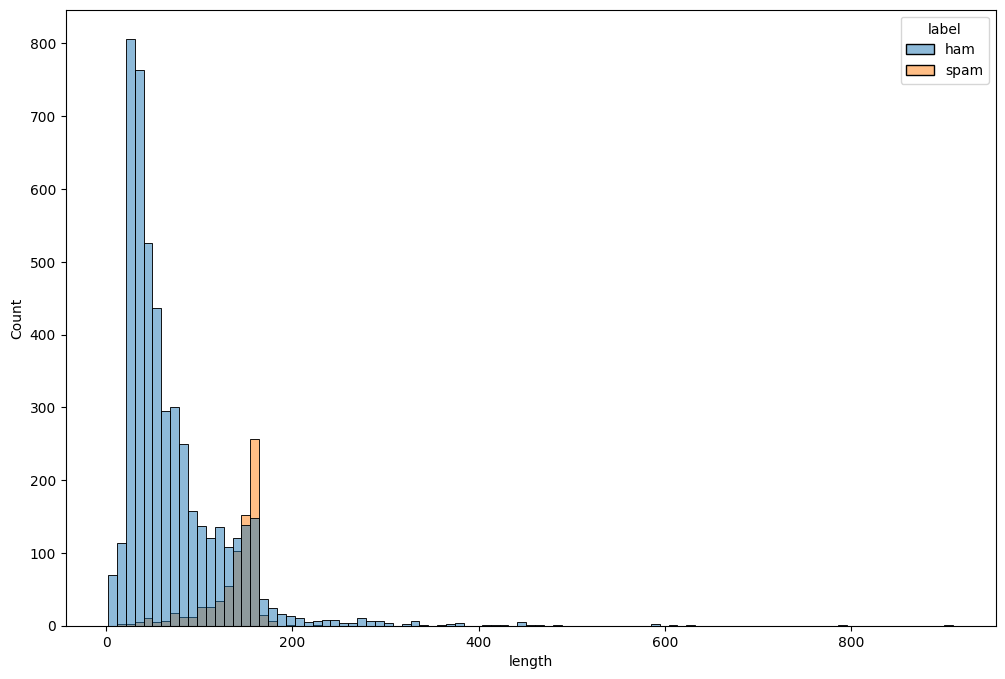

In [15]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df, x='length', hue='label')

We can see that spam email's content often longer than ham

#### Build word cloud

In [16]:
def plot_wordcloud(data):
    text = ' '.join(data['text'].astype(str).str.lower().tolist())
    stopwords = set(wordcloud.STOPWORDS)

    word_cloud = wordcloud.WordCloud(width = 800, height = 800, 
                                    background_color ='white', 
                                    stopwords = stopwords, 
                                    min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(word_cloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    
    plt.show() 

In [17]:
df_spam = df[df['spam'] == 1]
df_ham = df[df['spam'] == 0]

##### Check ham email

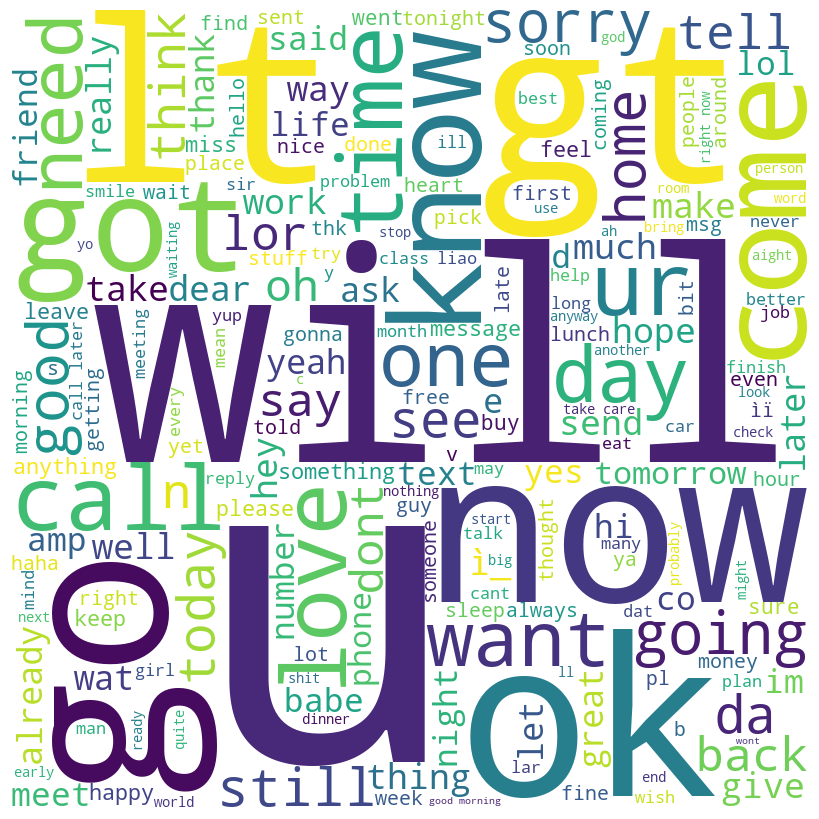

In [18]:
plot_wordcloud(df_ham)

##### Check spam email

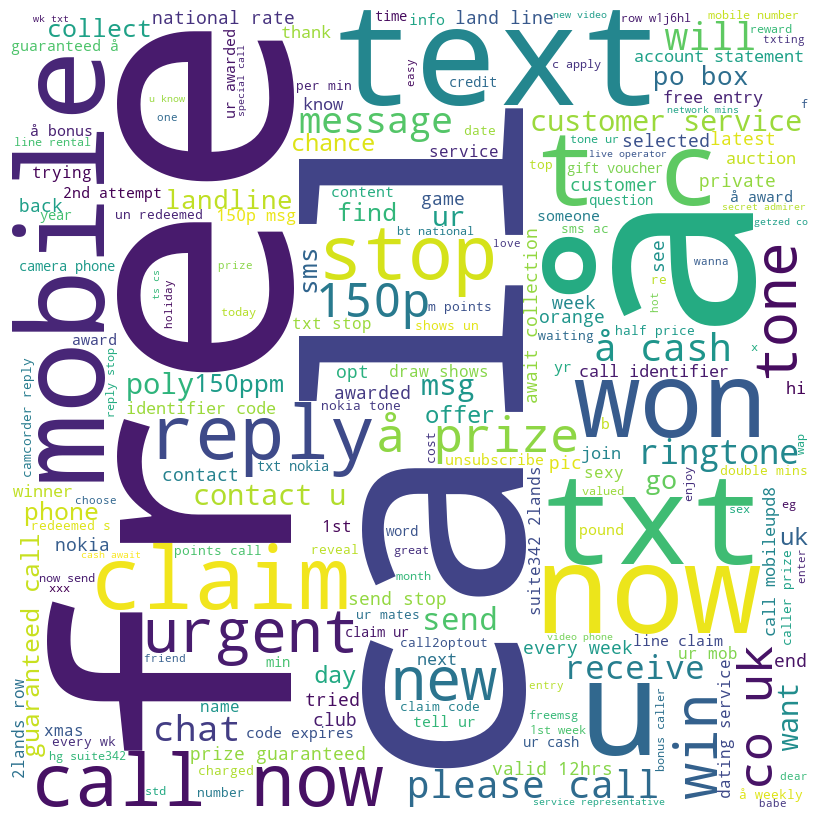

In [19]:
plot_wordcloud(df_spam)

### Text Preprocessing

#### Remove punctuation and stopwords

In [20]:
def text_process(data):
    
    no_punctuation = [c for c in data if c not in string.punctuation]
    no_punctuation = ''.join(no_punctuation).split()
    
    no_punctuation_no_stopwords = ' '.join([word.lower() for word in no_punctuation if word.lower() not in stopwords.words("english")])
        
    return no_punctuation_no_stopwords

In [21]:
df['clean_text'] = df['text'].apply(text_process)

df.head()

,label,text,spam,length,clean_text
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,U dun say so early hor... U c already then say...,0,49,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah dont think goes usf lives around though


#### Calculate word frequency

In [22]:
ham_words = Counter()
spam_words = Counter()

for msg in df[df['spam'] == 0]['clean_text'].apply(str.split):
    ham_words.update(msg)

for msg in df[df['spam'] == 1]['clean_text'].apply(str.split):
    spam_words.update(msg)

In [23]:
ham_top_30 = pd.DataFrame(ham_words.most_common(30), columns=['words', 'count'])
spam_top_30 = pd.DataFrame(spam_words.most_common(30), columns=['words', 'count'])

<AxesSubplot: xlabel='count', ylabel='words'>

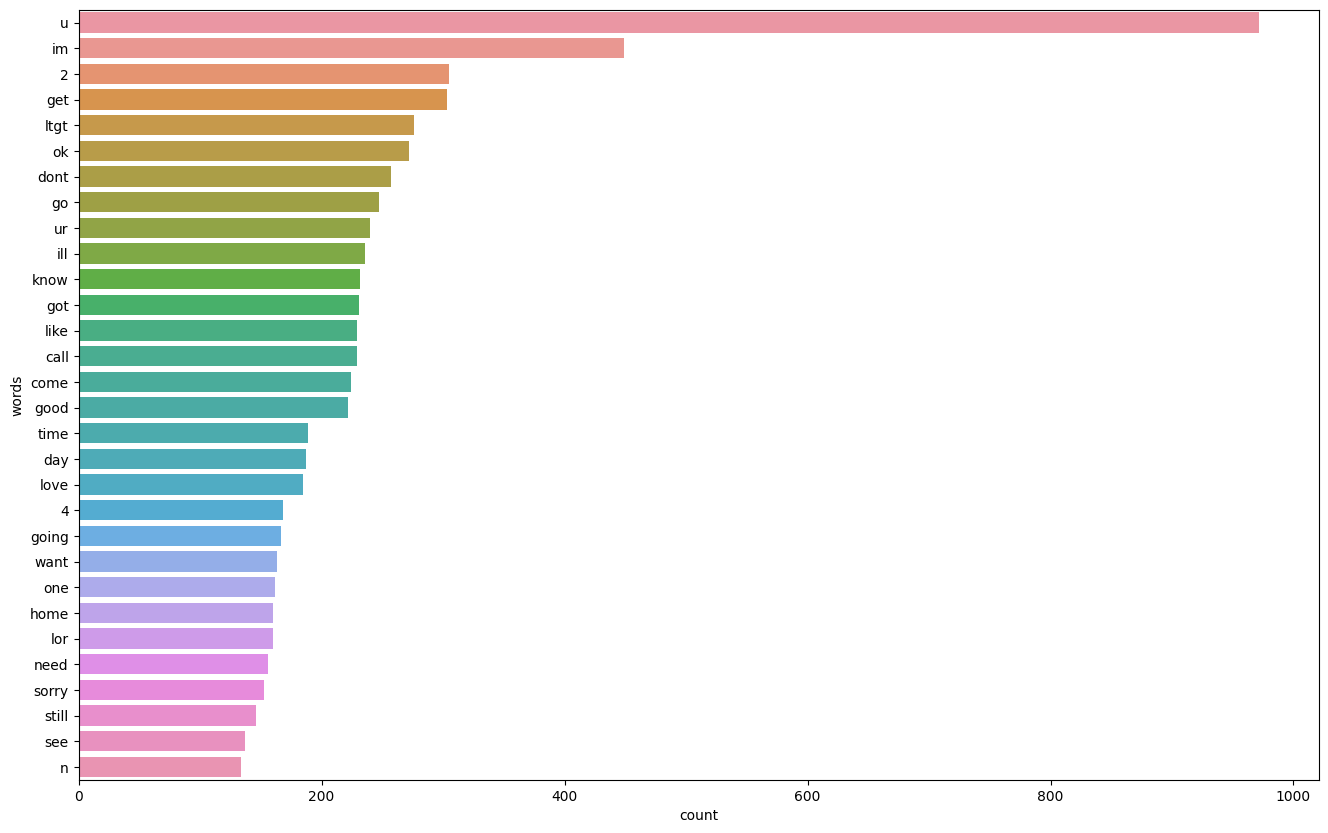

In [24]:
plt.figure(figsize=(16, 10))
sns.barplot(data=ham_top_30, y='words', x='count')

<AxesSubplot: xlabel='count', ylabel='words'>

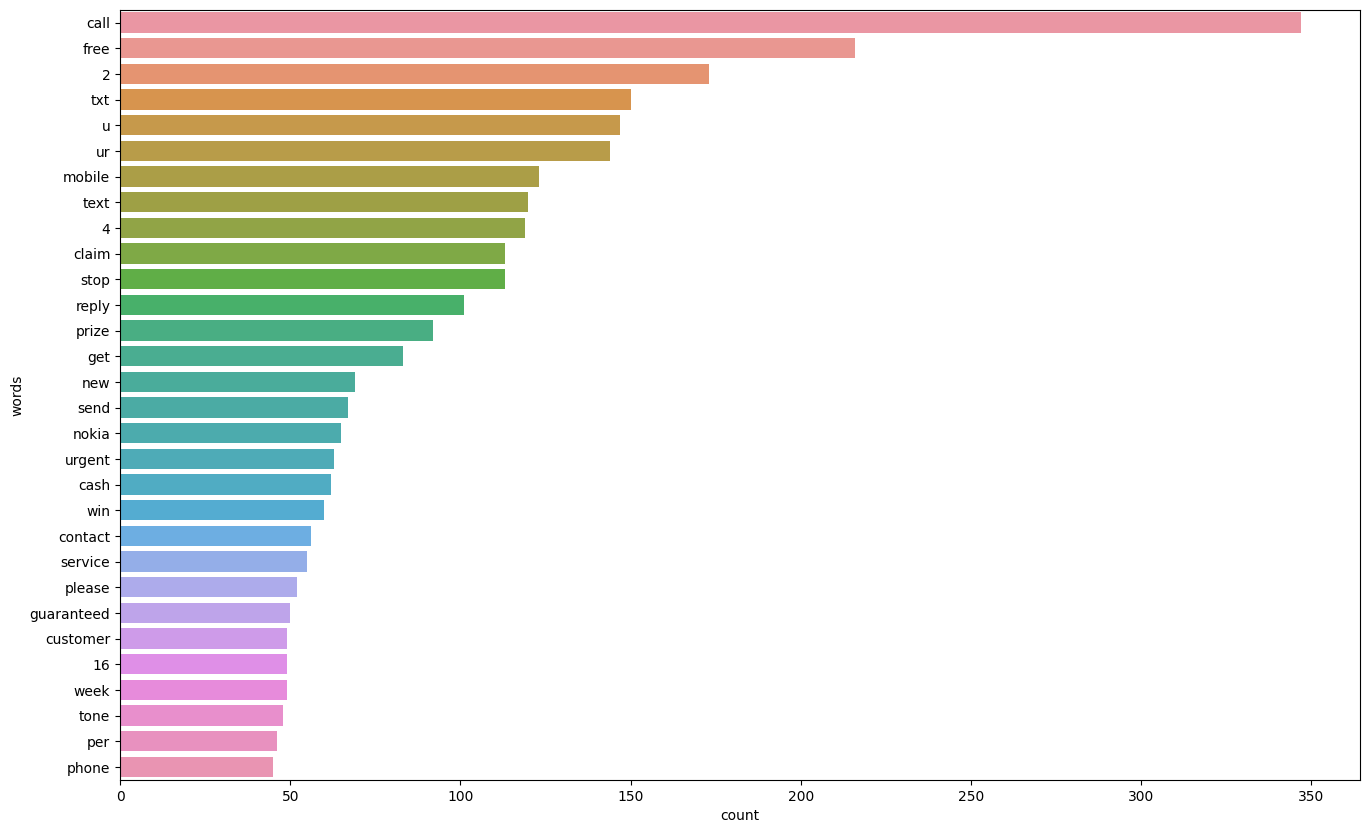

In [25]:
plt.figure(figsize=(16, 10))
sns.barplot(data=spam_top_30, y='words', x='count')

#### Vectorization

In [26]:
X = df['clean_text']
y = df['spam']

In [27]:
vect = CountVectorizer()

X_processed = vect.fit_transform(X)

In [28]:
tfidf_transformer = TfidfTransformer()

X_processed = tfidf_transformer.fit_transform(X_processed)

#### Scaling

In [29]:
scaler = MaxAbsScaler() 

X_processed = scaler.fit_transform(X_processed)

### Modeling

#### Find best model for modeling

In [30]:
data = {
    'gnb':{
        'model': GaussianNB(),
        'params':{}
    },
    'mnb':{
        'model': MultinomialNB(),
        'params':{}
    },
}

In [31]:
scores = []
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

for model_name, mp in data.items():
    clf = GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(X_processed.toarray(), y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

result = pd.DataFrame(scores, columns=['model','best_score','best_params'])

In [32]:
result.head()

,model,best_score,best_params
0,gnb,0.891839,{}
1,mnb,0.974888,{}


From the table above we can see that MultinomialNB give us the best result

#### Build the model

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.3, random_state=10)

In [34]:
model = MultinomialNB()

model.fit(X_train, y_train)

MultinomialNB()

### Model Evaluation

In [35]:
model.score(X_test, y_test)

0.9832535885167464

### Confusion Matrix

In [36]:
y_pred = model.predict(X_test)

Text(50.722222222222214, 0.5, 'Truth')

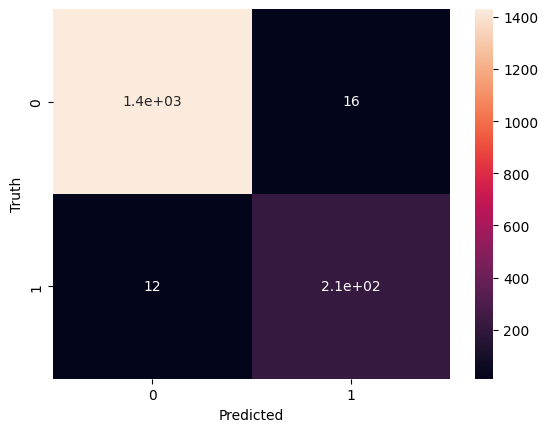

In [37]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(data=cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

As the result in the confusion matrix, we can see that our model work good but with few faults

### Save the model

In [38]:
with open('EmailDetection_model', 'wb') as f:
    pickle.dump(model, f)